<a href="https://colab.research.google.com/github/RafaelSdeSouza/astrostats-2025/blob/main/PyMC_Normal_errors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## See more in https://www.bayesianmodelsforastrophysicaldata.com/


In [ ]:
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Assuming data is already read using pandas as in your original script
path_to_data = 'https://raw.githubusercontent.com/astrobayes/BMAD/master/data/Section_10p1/M_sigma.csv'
data_frame = dict(pd.read_csv(path_to_data))
obsx = np.array(data_frame['obsx'])
errx = np.array(data_frame['errx'])
obsy = np.array(data_frame['obsy'])
erry = np.array(data_frame['erry'])
N = len(obsx)

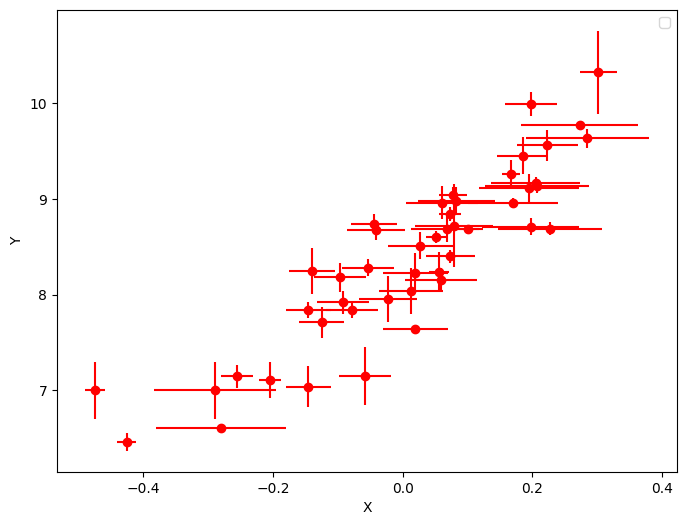

In [ ]:
# Plotting
plt.figure(figsize=(8, 6))
sns.scatterplot(x=obsx, y=obsy, color="red")
plt.errorbar(obsx, obsy, xerr=errx, yerr=erry, fmt='o', color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [ ]:
with pm.Model() as model:
    # Define priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    epsilon = pm.HalfNormal('epsilon', sigma=1)
    x_true = pm.Normal('x', mu=0, sigma=10, shape=N)
    mu = pm.Deterministic('mu', alpha + beta * x_true)

    # Likelihood
    y_true = pm.Normal('y', mu=mu, sigma=epsilon)
    obsx_like = pm.Normal('obsx', mu=x_true, sigma=errx, observed=obsx)
    obsy_like = pm.Normal('obsy', mu=y_true, sigma=erry, observed=obsy)


    # Inference
    trace = pm.sample(5000, chains=3, tune=2000, target_accept=0.95)

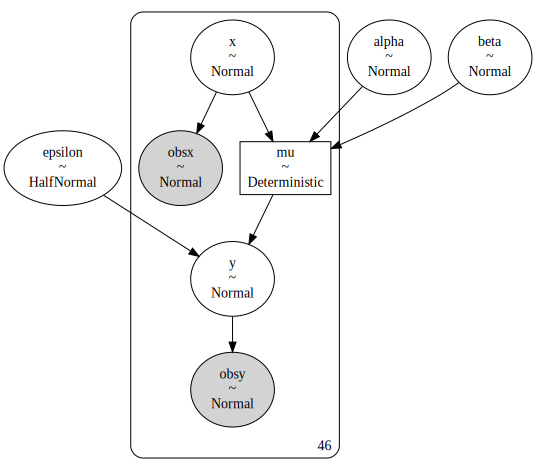

In [ ]:
pm.model_to_graphviz(model)

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'epsilon'}>], dtype=object)

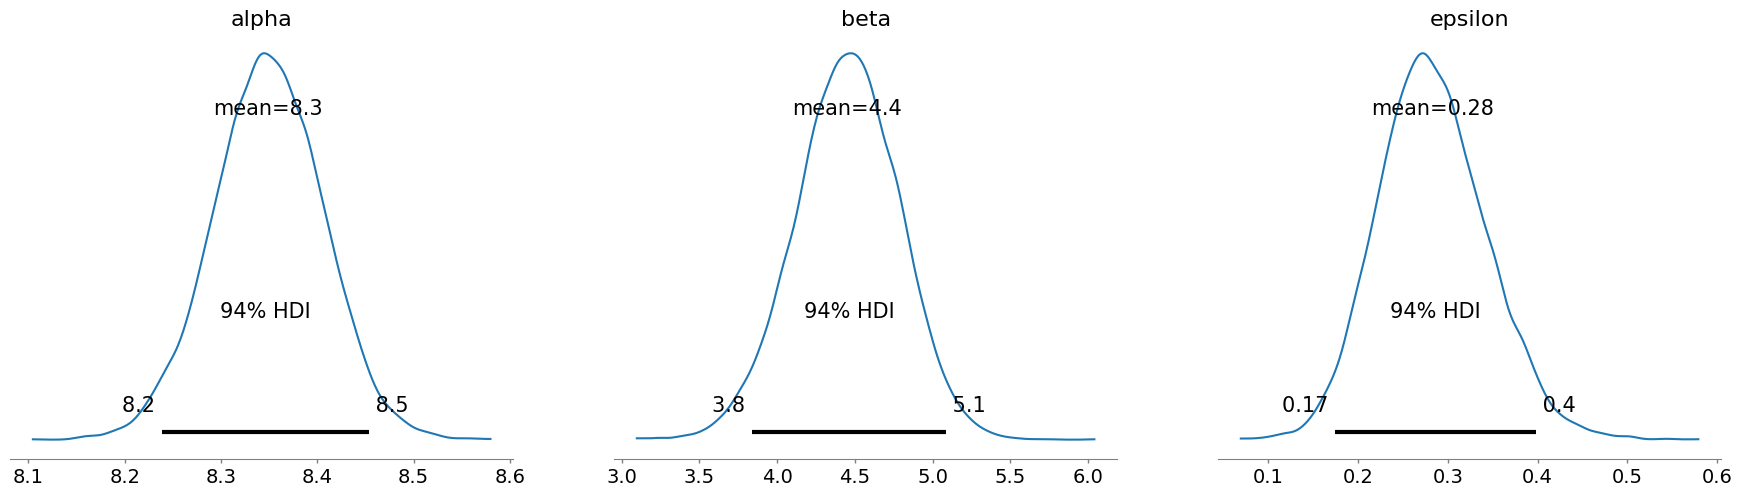

In [ ]:
pm.plot_posterior(trace, var_names=['alpha', 'beta', 'epsilon'])

In [ ]:
# Output
pm.summary(trace, var_names=['alpha', 'beta', 'epsilon']).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,8.349,0.057,8.238,8.453,0.001,0.000,9842.0,11025.0,1.0
beta,4.448,0.333,3.838,5.088,0.004,0.003,6951.0,9544.0,1.0
epsilon,0.283,0.060,0.174,0.399,0.001,0.001,3157.0,4043.0,1.0


In [ ]:
# Extracting posterior samples
beta_sample  =  trace.posterior['beta'].values.flatten()
alpha_samples = trace.posterior['alpha'].values.flatten()

# Generate a range of x values for plotting the fit
x_range = np.linspace(1.2*obsx.min(), 1.2*obsx.max(), 100)


In [ ]:
# Calculate the mean and confidence intervals for each x value
mean_y = []
ci_50_lower = []
ci_50_upper = []
ci_95_lower = []
ci_95_upper = []

for x in x_range:
    y = alpha_samples + beta_sample* x
    mean_y.append(np.mean(y))
    ci_50 = np.percentile(y, [25, 75])
    ci_50_lower.append(ci_50[0])
    ci_50_upper.append(ci_50[1])
    ci_95 = np.percentile(y, [2.5, 97.5])
    ci_95_lower.append(ci_95[0])
    ci_95_upper.append(ci_95[1])

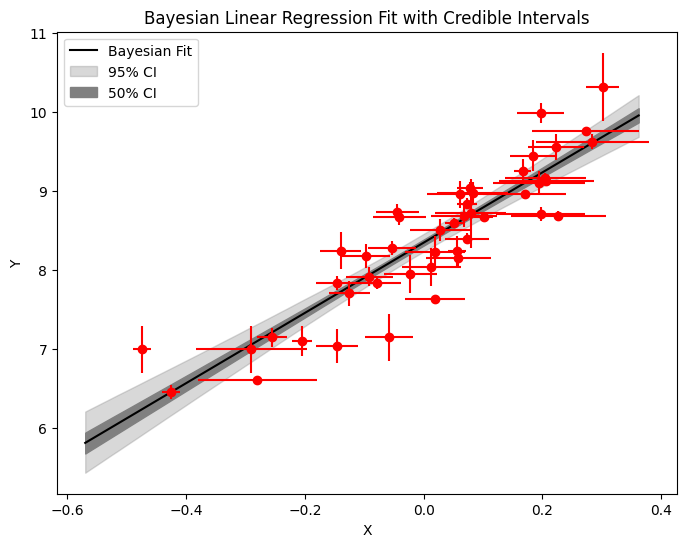

In [ ]:
# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x_range, mean_y, label='Bayesian Fit', color='black')
sns.scatterplot(x=obsx, y=obsy, color="red")
plt.errorbar(obsx, obsy, xerr=errx, yerr=erry, fmt='o', color='red')
plt.fill_between(x_range, ci_95_lower, ci_95_upper, color='gray', alpha=0.3, label='95% CI')
plt.fill_between(x_range, ci_50_lower, ci_50_upper, color='gray', alpha=1, label='50% CI')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Bayesian Linear Regression Fit with Credible Intervals')
plt.legend()
plt.show()

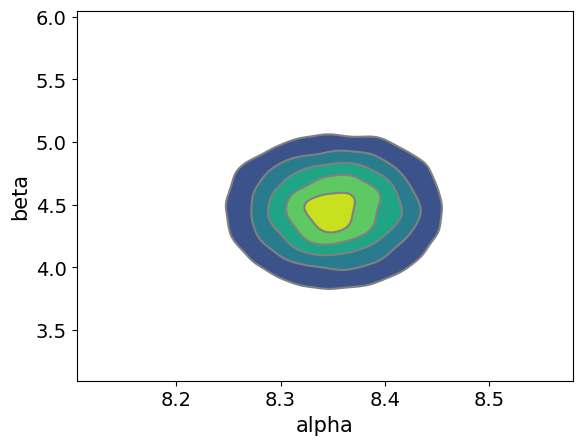

In [ ]:
import arviz as az
az.plot_pair(trace, var_names=['alpha', 'beta'], kind='kde')
plt.show()